In [4]:
import pandas as pd
import numpy as np
import os
import torch

from torch.utils.data import Dataset

import re
from bs4 import BeautifulSoup

In [5]:
dataset_folder_path = '/home/murtaza/University_Data/deep_learning/assignment4/dataset'

In [6]:
answers_df = pd.read_csv(f'{dataset_folder_path}/Answers.csv', encoding='latin1')
questions_df = pd.read_csv(f'{dataset_folder_path}/Questions.csv', encoding='latin1')
tags_df = pd.read_csv(f'{dataset_folder_path}/Tags.csv', encoding='latin1')


In [7]:
questions_df.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [8]:
answers_df.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


In [9]:
tags_df.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [10]:

questions_df.shape, answers_df.shape, tags_df.shape

((607282, 6), (987122, 6), (1885078, 2))

In [11]:
# Step 1: Rename columns for clarity
questions_df = questions_df.rename(columns={
    'Id': 'question_id',
    'Score': 'question_score',
    'Title': 'question_title',
    'Body': 'question_body'
})

answers_df = answers_df.rename(columns={
    'ParentId': 'question_id',
    'Body': 'answer_body',
    'Score': 'answer_score'
})

tags_df = tags_df.rename(columns={'Id': 'question_id'})

questions_df['question_text'] = questions_df['question_title'] + ' ' + questions_df['question_body']

In [12]:
# Sort by score so highest answer comes first per question
answers_df_sorted = answers_df.sort_values(by=['question_id', 'answer_score'], ascending=[True, False])

# Drop duplicates to keep only the top answer per question
top_answers_df = answers_df_sorted.drop_duplicates(subset='question_id', keep='first')


In [13]:

# Step 2: Merge answers with questions
df = pd.merge(
    questions_df[['question_id', 'question_text']],
    top_answers_df[['question_id', 'answer_body']],
    on='question_id',
    how='inner'
)


In [14]:
df = df.sample(n=1000, random_state=42).reset_index(drop=True)


In [15]:


def preprocess_text(text):
    if pd.isnull(text):
        return ""

    # 1. Convert to lowercase
    text = text.lower()
    
    # 2. Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # 3. Replace code blocks with [code] (optional enhancement)
    text = re.sub(r'```.*?```', '[code]', text, flags=re.DOTALL)  # multiline code blocks
    text = re.sub(r'<code>.*?</code>', '[code]', text, flags=re.DOTALL)  # <code> tags

    # 4. Remove special characters (keeping basic punctuation)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    
    # 5. Add start/end tokens
    text = f"<murtaza_msds24040> {text.strip()} </murtaza_msds24040>"
    
    return text


In [16]:
df['question_text'] = df['question_text'].apply(preprocess_text)
df['answer_body'] = df['answer_body'].apply(preprocess_text)


In [17]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")


Train: 600, Validation: 200, Test: 200


3. Tokenization

In [57]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("openai-community/openai-gpt")
tokenizer.add_special_tokens({'pad_token': '[PAD]','additional_special_tokens': ['<murtaza_msds24040>', '</murtaza_msds24040>']})
tokenizer.pad_token = '[PAD]'


In [19]:
tokenizer.model_max_length

512

In [20]:
def tokenize_text(text, max_length=512):
    return tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )


In [21]:
train_question_encodings = tokenize_text(train_df['question_text'].tolist())
train_answer_encodings = tokenize_text(train_df['answer_body'].tolist())

val_question_encodings = tokenize_text(val_df['question_text'].tolist())
val_answer_encodings = tokenize_text(val_df['answer_body'].tolist())

test_question_encodings = tokenize_text(test_df['question_text'].tolist())
test_answer_encodings = tokenize_text(test_df['answer_body'].tolist())


In [22]:
def mask_pad_tokens(labels, pad_token_id):
    # labels is a tensor of shape (batch_size, seq_len)
    return torch.where(labels == pad_token_id, torch.tensor(-100), labels)

train_answer_labels = mask_pad_tokens(train_answer_encodings['input_ids'], tokenizer.pad_token_id)
val_answer_labels = mask_pad_tokens(val_answer_encodings['input_ids'], tokenizer.pad_token_id)
test_answer_labels = mask_pad_tokens(test_answer_encodings['input_ids'], tokenizer.pad_token_id)


In [23]:
train_answer_labels

tensor([[40479,   512,   759,  ...,  -100,  -100,  -100],
        [40479,  4327,  6422,  ...,  -100,  -100,  -100],
        [40479,   512,   759,  ...,  -100,  -100,  -100],
        ...,
        [40479,   620,   704,  ...,  -100,  -100,  -100],
        [40479,   512,   604,  ...,  -100,  -100,  -100],
        [40479,  3319, 23356,  ...,  -100,  -100,  -100]])

In [24]:
train_answer_encodings['input_ids']

tensor([[40479,   512,   759,  ..., 40478, 40478, 40478],
        [40479,  4327,  6422,  ..., 40478, 40478, 40478],
        [40479,   512,   759,  ..., 40478, 40478, 40478],
        ...,
        [40479,   620,   704,  ..., 40478, 40478, 40478],
        [40479,   512,   604,  ..., 40478, 40478, 40478],
        [40479,  3319, 23356,  ..., 40478, 40478, 40478]])

4. Data Loader

In [25]:
class QADataset(Dataset):
    def __init__(self, input_encodings, attention_masks, labels):
        self.input_ids = input_encodings
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return self.input_ids.size(0)  # since it's already a tensor

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }


In [26]:
train_dataset = QADataset(
    input_encodings=train_question_encodings['input_ids'],
    attention_masks=train_question_encodings['attention_mask'],
    labels=train_answer_labels  # list of tensors with -100 for padded tokens
)

val_dataset = QADataset(
    input_encodings=val_question_encodings['input_ids'],
    attention_masks=val_question_encodings['attention_mask'],
    labels=val_answer_labels
)

test_dataset = QADataset(
    input_encodings=test_question_encodings['input_ids'],
    attention_masks=test_question_encodings['attention_mask'],
    labels=test_answer_labels
)


In [40]:
from torch.utils.data import DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


5. Model Architecture

In [41]:
import torch
import torch.nn as nn
import math


In [42]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

        if mask is not None:
            # mask = mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn, V)
        return output, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.linear_Q = nn.Linear(d_model, d_model)
        self.linear_K = nn.Linear(d_model, d_model)
        self.linear_V = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention()
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)

        Q = self.linear_Q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.linear_K(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.linear_V(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        if mask is not None:
            # mask = mask.unsqueeze(1)  # (batch_size, 1, 1, seq_len)
            mask = mask.unsqueeze(1).unsqueeze(2)

        out, _ = self.attention(Q, K, V, mask=mask)
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.out_proj(out)


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))


class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_out = self.attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x


class MiniTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=8, d_ff=512, num_layers=2, max_len=1024):
        super(MiniTransformer, self).__init__()
        # self.embedding = nn.Embedding(vocab_size, d_model)
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=tokenizer.pad_token_id)

        self.pos_encoding = PositionalEncoding(d_model, max_len)

        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])

        self.output_proj = nn.Linear(d_model, vocab_size)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.pos_encoding(x)

        for layer in self.layers:
            x = layer(x, mask=attention_mask)

        logits = self.output_proj(x)
        return logits


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [61]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR


vocab_size = len(tokenizer)
model = MiniTransformer(vocab_size=vocab_size).to(device)

criterion = CrossEntropyLoss(ignore_index=-100)  # ignore padding
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=10)


In [45]:

def save_checkpoint(model, optimizer, epoch, loss, path='checkpoint.pt'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, path)

def calculate_perplexity(loss):
    return torch.exp(loss)


In [46]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        output = model(input_ids, attention_mask)
        
        # Reshape for loss computation
        output = output.view(-1, output.size(-1))
        labels = labels.view(-1)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    perplexity = calculate_perplexity(torch.tensor(avg_loss))
    return avg_loss, perplexity.item()

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            output = model(input_ids, attention_mask)
            output = output.view(-1, output.size(-1))
            labels = labels.view(-1)

            loss = criterion(output, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    perplexity = calculate_perplexity(torch.tensor(avg_loss))
    return avg_loss, perplexity.item()



In [47]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import defaultdict

# Helper function for generation
def greedy_decode(model, input_ids, attention_mask, tokenizer, max_length=50, device='cpu'):
    model.eval()
    with torch.no_grad():
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        generated = input_ids

        for _ in range(max_length):
            outputs = model(generated, attention_mask)
            next_token_logits = outputs[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)
            generated = torch.cat((generated, next_token), dim=1)
            attention_mask = torch.cat((attention_mask, torch.ones_like(next_token)), dim=1)
        return generated

# Helper function to decode token IDs to strings
def decode_predictions(pred_ids, tokenizer):
    return [tokenizer.decode(pred, skip_special_tokens=True).strip() for pred in pred_ids]

# BLEU score calculation
def calculate_bleu(model, val_loader, tokenizer, device, max_length=50):
    model.eval()
    bleu_scores = []
    smooth_fn = SmoothingFunction().method4

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            generated_ids = greedy_decode(model, input_ids, attention_mask, tokenizer, max_length=max_length, device=device)
            decoded_preds = decode_predictions(generated_ids, tokenizer)

            # Convert labels to strings for BLEU scoring
            label_ids = labels.clone()
            label_ids[label_ids == -100] = tokenizer.pad_token_id  # replace -100 with pad_token_id
            decoded_labels = decode_predictions(label_ids, tokenizer)

            for ref, hyp in zip(decoded_labels, decoded_preds):
                ref_tokens = ref.split()
                hyp_tokens = hyp.split()
                score = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smooth_fn)
                bleu_scores.append(score)

    return sum(bleu_scores) / len(bleu_scores)

def train_model_with_metrics(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    tokenizer,
    device, 
    epochs=10, 
    patience=3, 
    checkpoint_path='best_model.pt',
    max_gen_len=50
):
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    history = defaultdict(list)

    for epoch in range(epochs):
        train_loss, train_ppl = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_ppl = evaluate(model, val_loader, criterion, device)
        bleu = calculate_bleu(model, val_loader, tokenizer, device, max_length=max_gen_len)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_ppl'].append(train_ppl)
        history['val_ppl'].append(val_ppl)
        history['bleu'].append(bleu)

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f} | Train PPL: {train_ppl:.2f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val PPL:   {val_ppl:.2f} | BLEU: {bleu:.4f}")

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            print("  Validation loss decreased, saving model...")
            torch.save(model.state_dict(), checkpoint_path)
        else:
            epochs_no_improve += 1
            print(f"  No improvement in validation loss for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return history


In [48]:
import torch
torch.cuda.empty_cache()


In [49]:
history = train_model_with_metrics(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    tokenizer=tokenizer,
    device=device,
    epochs=10,
    patience=3,
    checkpoint_path='best_model.pt',
    max_gen_len=50  # can be adjusted
)


Epoch 1/10:
  Train Loss: 10.0132 | Train PPL: 22319.73
  Val Loss:   9.1129 | Val PPL:   9071.36 | BLEU: 0.0419
  Validation loss decreased, saving model...
Epoch 2/10:
  Train Loss: 8.5274 | Train PPL: 5051.10
  Val Loss:   7.9447 | Val PPL:   2820.54 | BLEU: 0.0419
  Validation loss decreased, saving model...
Epoch 3/10:
  Train Loss: 7.6240 | Train PPL: 2046.69
  Val Loss:   7.3353 | Val PPL:   1533.51 | BLEU: 0.0419
  Validation loss decreased, saving model...
Epoch 4/10:
  Train Loss: 7.1674 | Train PPL: 1296.53
  Val Loss:   7.0649 | Val PPL:   1170.11 | BLEU: 0.0419
  Validation loss decreased, saving model...
Epoch 5/10:
  Train Loss: 6.9513 | Train PPL: 1044.46
  Val Loss:   6.9474 | Val PPL:   1040.46 | BLEU: 0.0419
  Validation loss decreased, saving model...
Epoch 6/10:
  Train Loss: 6.8542 | Train PPL: 947.90
  Val Loss:   6.8896 | Val PPL:   982.00 | BLEU: 0.0419
  Validation loss decreased, saving model...
Epoch 7/10:
  Train Loss: 6.7957 | Train PPL: 894.01
  Val Loss:

Visualization

In [50]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # Plot Loss
    axs[0].plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    axs[0].plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    axs[0].set_title('Loss per Epoch')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Perplexity
    axs[1].plot(epochs, history['train_ppl'], label='Train Perplexity', marker='o')
    axs[1].plot(epochs, history['val_ppl'], label='Validation Perplexity', marker='o')
    axs[1].set_title('Perplexity per Epoch')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Perplexity')
    axs[1].legend()
    axs[1].grid(True)

    # Plot BLEU score
    axs[2].plot(epochs, history['bleu'], label='BLEU Score', marker='o', color='green')
    axs[2].set_title('BLEU Score per Epoch')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('BLEU Score')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


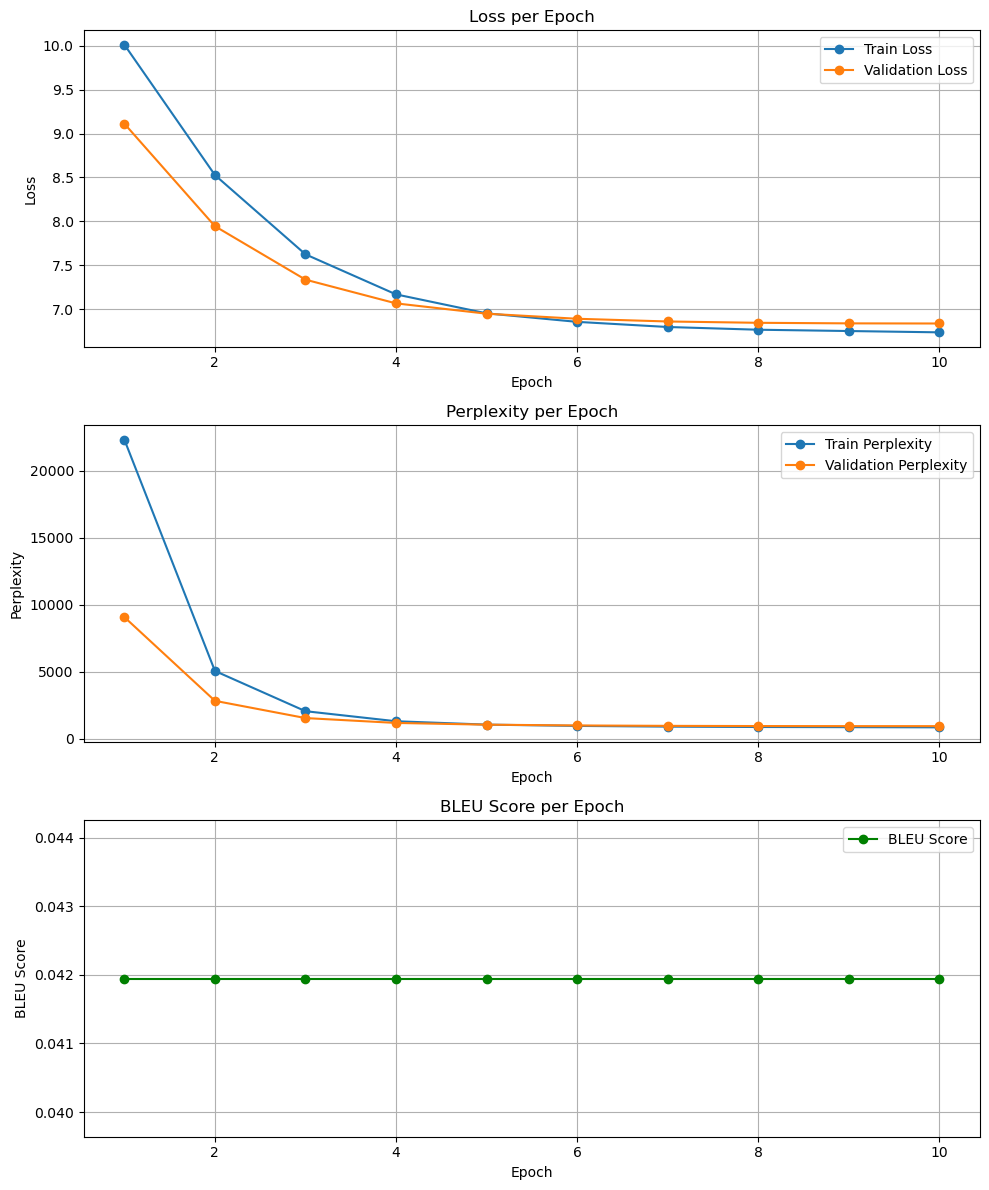

In [51]:
plot_training_history(history)


Testing

In [ ]:
from torch.utils.data import DataLoader
from nltk.translate.bleu_score import corpus_bleu
import torch
from tqdm import tqdm

def generate_answer(model, input_ids, attention_mask, tokenizer, device, max_length=50):
    model.eval()
    input_ids = input_ids.unsqueeze(0).to(device)
    attention_mask = attention_mask.unsqueeze(0).to(device)
    generated_ids = []
    
    with torch.no_grad():
        for _ in range(max_length):
            output = model(input_ids, attention_mask)
            next_token_logits = output[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1)
            generated_ids.append(next_token.item())

            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
            attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=device)], dim=1)

            if next_token.item() == tokenizer.eos_token_id:
                break

    return tokenizer.decode(generated_ids, skip_special_tokens=True)

def evaluate_test_set(model, test_loader, tokenizer, device, max_gen_len=50):
    model.eval()
    predictions = []
    references = []
    results = []

    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']  

        for i in range(input_ids.size(0)):
            pred = generate_answer(model, input_ids[i], attention_mask[i], tokenizer, device, max_length=max_gen_len)
            true = tokenizer.decode([id for id in labels[i].tolist() if id != -100 and id != tokenizer.pad_token_id], skip_special_tokens=True)

            predictions.append(pred.split())
            references.append([true.split()])
            results.append((pred, true))

    bleu = corpus_bleu(references, predictions)
    print(f"Test BLEU Score: {bleu:.4f}")
    return results, bleu


In [65]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.to(device)

# Run test
results, bleu_score = evaluate_test_set(model, test_loader, tokenizer, device)


Testing: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]

Test BLEU Score: 0.0037
